In [8]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, spearmanr, ttest_ind, ttest_rel
import torch
import transformers
from transformers import pipeline
from tqdm.auto import tqdm
tqdm.pandas()

sns.set(style='whitegrid', palette='Set2')

transformers.logging.set_verbosity_warning()

def pearsoncorr(a, b, nan_policy):
    a = a.values
    b = b.values
    if nan_policy == 'omit':
        na = np.logical_or(np.isnan(a), np.isnan(b))
    return pearsonr(a[~na], b[~na])

## Loading Prasada 2006 & 2013 data and merging them with novel data

In [9]:
df_mean = pd.read_csv('data/novel_stimuli_plus_prasada_data.csv')
df_mean['source'] = 'prasada'  # label data as coming from Prasada experiments

# replace a few columns names so we can merge data more easily
df_mean.columns = df_mean.columns.str.replace('.', '_')
df_mean = df_mean.rename(columns={
    'connection_type': 'type',
    'Truth_judgment': 'generic',
    'Prevalence_estimate': 'prevalence',
    'Cue_validity_estimate': 'cue_validity',
})

# transform the Prasada measures to a 0-1 scale
df_mean.prevalence = df_mean.prevalence / 100  # prevalence is a percentage
df_mean.by_virtue_of = (df_mean.by_virtue_of - 1) / 6  # by_virtue_of is a 7-point Likert scale
df_mean.generic = (df_mean.generic + 3) / 6  # generics truth is a 7-point scale from -3 to +3
df_mean.cue_validity = (df_mean.cue_validity + 3) / 6  # cue validity also goes from -3 to +3

display(df_mean.head())

/var/folders/py/jxr8v1g13rs0lgpdf083hc7c0000gn/T/ipykernel_84500/1925466544.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_mean.columns = df_mean.columns.str.replace('.', '_')


,type,item,subject,is_are,property,origin,generic,cue_validity,prevalence,in_general,by_virtue_of,causal_essence,statistical,formal,should,source
0,principled,airplanes have wings,airplanes,are they,have wings,2006 & 2013,0.985000,0.518333,0.9613,3.83,0.963333,2.50,4.56,4.50,6.82,prasada
1,statistical,airplanes have passengers,airplanes,are they,have passengers,novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,prasada
2,principled,ambulances have sirens,ambulances,are they,have sirens,2006 & 2013,0.916667,0.745000,0.9796,5.50,0.786667,2.39,5.33,5.22,6.44,prasada
3,statistical,ambulances have seatbelts,ambulances,are they,have seatbelts,novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,prasada
4,principled,americans live in america,Americans,are they,live in America,novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,prasada


In [10]:
df_mean = df_mean.merge(
    (
        pd.read_csv('data/novel_data.csv')
        .groupby(['type', 'item', 'subject', 'property', 'source'])
        .mean()
        .reset_index()
    ),
    how='outer').sort_values(['type', 'item', 'source']).reset_index(drop=True)
display(df_mean)

/var/folders/py/jxr8v1g13rs0lgpdf083hc7c0000gn/T/ipykernel_84500/1835562398.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


,type,item,subject,is_are,property,origin,generic,cue_validity,prevalence,in_general,by_virtue_of,causal_essence,statistical,formal,should,source
0,principled,airplanes have wings,airplanes,NaN,have wings,NaN,0.984848,0.575758,0.907407,NaN,0.939394,NaN,NaN,NaN,NaN,novel
1,principled,airplanes have wings,airplanes,are they,have wings,2006 & 2013,0.985000,0.518333,0.961300,3.83,0.963333,2.50,4.56,4.50,6.82,prasada
2,principled,ambulances have sirens,ambulances,NaN,have sirens,NaN,0.972222,0.666667,0.954545,NaN,0.878788,NaN,NaN,NaN,NaN,novel
3,principled,ambulances have sirens,ambulances,are they,have sirens,2006 & 2013,0.916667,0.745000,0.979600,5.50,0.786667,2.39,5.33,5.22,6.44,prasada
4,principled,americans live in america,Americans,NaN,live in America,NaN,0.900000,0.848485,0.888889,NaN,0.863636,NaN,NaN,NaN,NaN,novel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,statistical,wallets are made of leather,wallets,are they,are made of leather,2006,NaN,NaN,0.635300,5.67,0.185000,1.72,3.06,4.22,4.67,prasada
412,statistical,winters are snowy,winters,NaN,are snowy,NaN,0.651515,0.909091,0.791667,NaN,0.454545,NaN,NaN,NaN,NaN,novel
413,statistical,winters are snowy,winters,are they,are snowy,2006 & 2013,0.715000,0.763333,0.723900,6.00,0.583333,2.28,4.72,4.11,3.06,prasada
414,statistical,worms are used as bait,worms,NaN,are used as bait,NaN,0.766667,0.854167,0.681818,NaN,0.469697,NaN,NaN,NaN,NaN,novel


PearsonRResult(statistic=0.8683769260834479, pvalue=1.8250131016429144e-17)

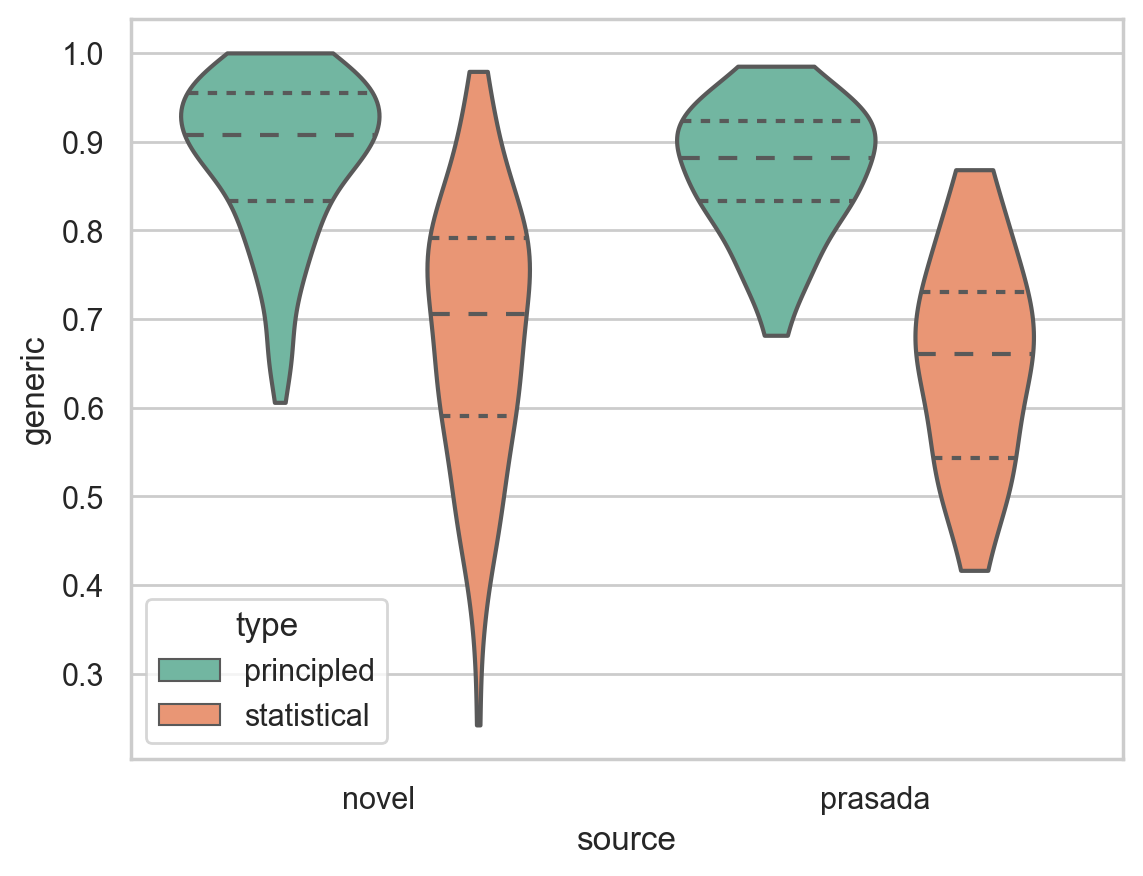

In [14]:
sns.violinplot(
    data=df_mean,
    x='source',
    y='generic',
    hue='type', hue_order=['principled', 'statistical'],
    cut=0,
    inner='quartiles',
)
pearsoncorr(df_mean[df_mean.source == 'prasada'].generic,
          df_mean[df_mean.source == 'novel'].generic,
          nan_policy='omit')

The bare generics truth judgments look quite similar across the two samples in terms of distribution (despite adding some novel controls). The two samples correlate quite strongly, too.

Overall, it seems like we've replicated the manipulation successfully, at least.

PearsonRResult(statistic=0.8587689393161729, pvalue=7.950136285094924e-26)

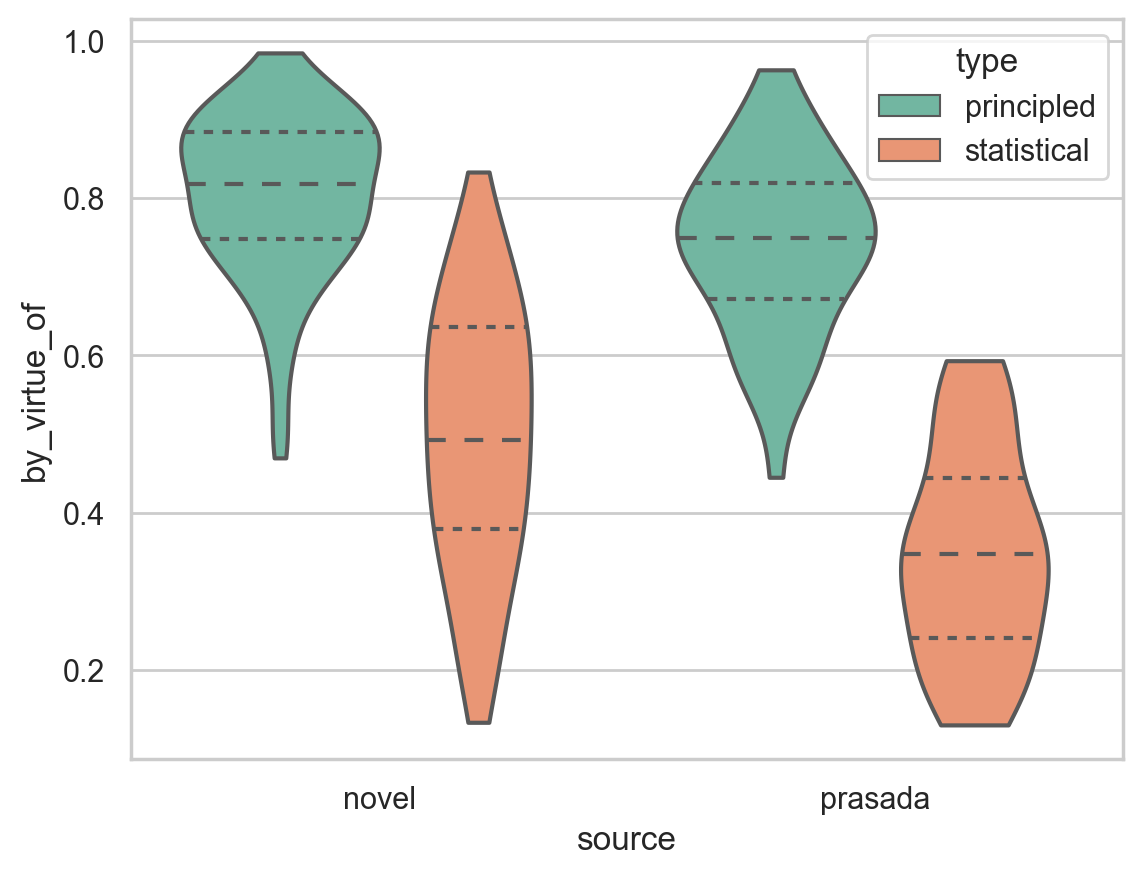

In [16]:
sns.violinplot(
    data=df_mean,
    x='source',
    y='by_virtue_of',
    hue='type', hue_order=['principled', 'statistical'],
    cut=0,
    inner='quartiles',
)
pearsoncorr(df_mean[df_mean.source == 'prasada'].by_virtue_of,
          df_mean[df_mean.source == 'novel'].by_virtue_of,
          nan_policy='omit')

The by-virtue-of ratings again look very similar between the Prasada data and our novel data. This is good, because we moved to the more transparent _because_ phrasing, whereas Prasada used a literal _by virtue of_ phrasing, but it doesn't seem to have changed the ratings very much.

PearsonRResult(statistic=0.7870266405825236, pvalue=6.175510305616261e-27)

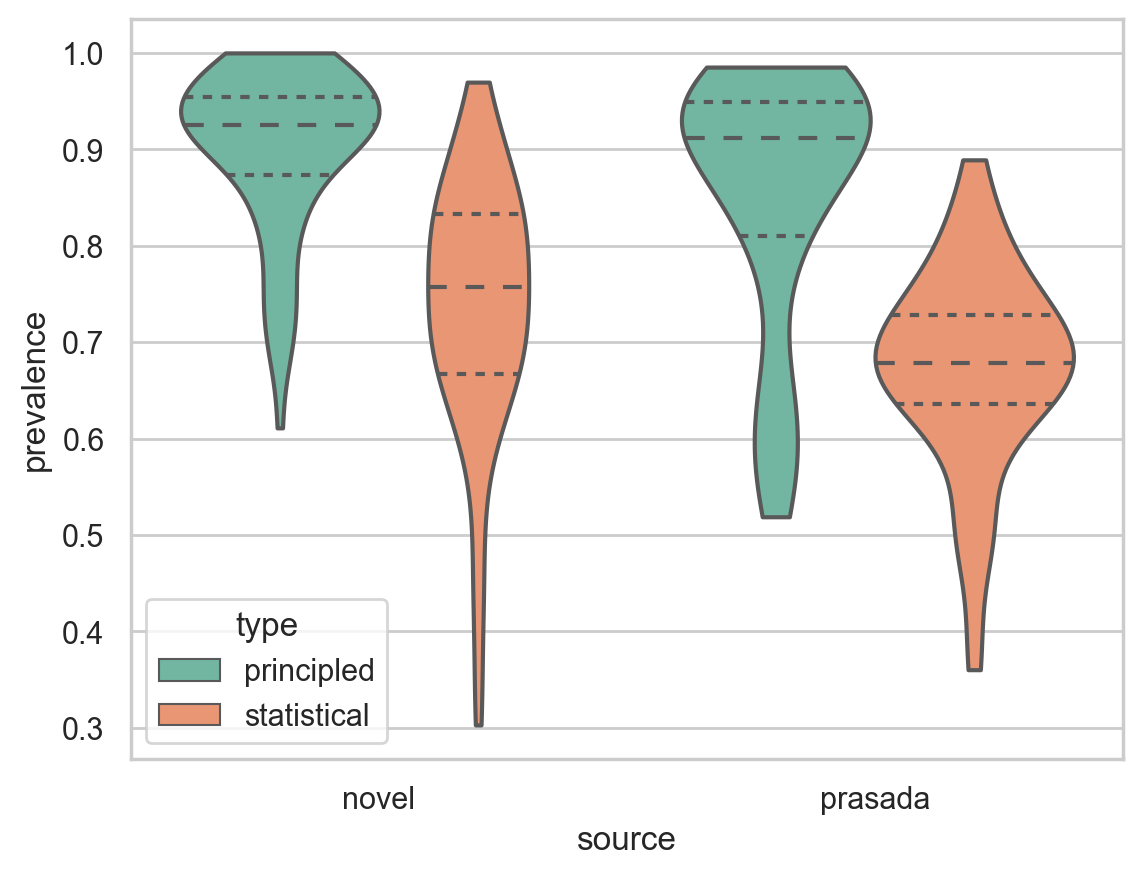

In [17]:
sns.violinplot(
    data=df_mean,
    x='source',
    y='prevalence',
    hue='type', hue_order=['principled', 'statistical'],
    cut=0,
    inner='quartiles',
)
pearsoncorr(df_mean[df_mean.source == 'prasada'].prevalence,
          df_mean[df_mean.source == 'novel'].prevalence,
          nan_policy='omit')

Prevalence looks quite good as well, although note that the rank correlation between the two datasets is a bit lower. That might be because we get ceiling effects for the principled connections, so the ranking at the top end is probably fairly arbitrary.

PearsonRResult(statistic=0.7787159973185083, pvalue=4.138720616683474e-12)

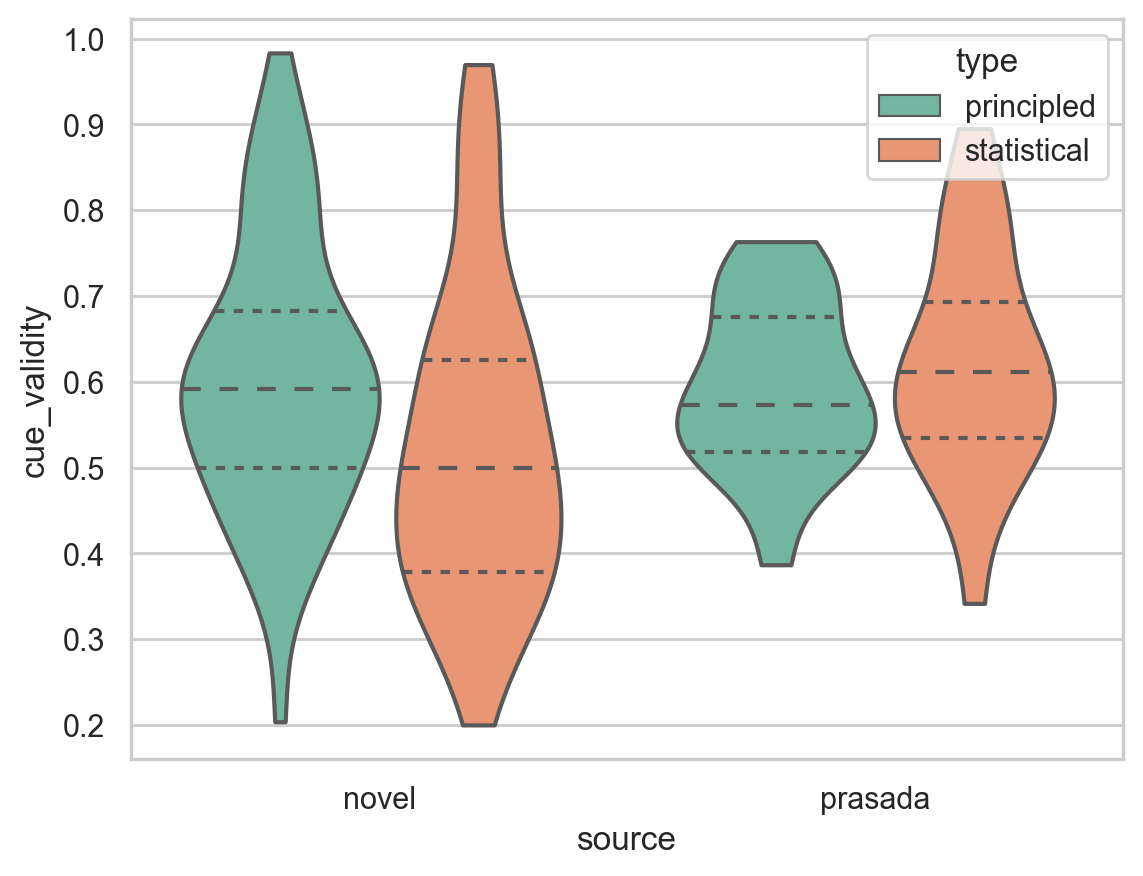

In [18]:
sns.violinplot(
    data=df_mean,
    x='source',
    y='cue_validity',
    hue='type', hue_order=['principled', 'statistical'],
    cut=0,
    inner='quartiles',
)
pearsoncorr(df_mean[df_mean.source == 'prasada'].cue_validity,
          df_mean[df_mean.source == 'novel'].cue_validity,
          nan_policy='omit')

The largest difference between the two samples is in the cue validity ratings. In the Prasada data cue validity is slightly lower, on average, for the statistical connections, but in our data it's the other way around.

The rank correlations are also somewhat lower because of this. It's still a fairly strong correlation however.

## Computing BERT cloze probabilities for the stimuli

In [59]:
# load large transformer model from huggingface to generate cloze probabilities
# using ALBERT here because A) it is very large and B) its tokenizer is compatible with our task
nlp = pipeline('fill-mask', model='albert-xxlarge-v2')

In [60]:
# function for extracting final word / cloze probabilities from transformer models
def predict_final_word(subject, prop):
    targets = nlp.tokenizer.tokenize(prop.lower())
    stub = subject + ' '
    p = 1
    for i, target in enumerate(targets):
        outputs = nlp(stub +
                      ''.join(targets[:i]).replace('#', '') +
                      ''.join([nlp.tokenizer.mask_token] * (len(targets) - i)) +
                      '.',
                      targets=targets[i])
        for output in outputs:
            if isinstance(output, list):
                output = output[0]
            if output['token_str'] == target.lstrip('▁'):
                p *= output['score']
                break
        
    return p

### Quick test of BERT cloze probabilities

In [61]:
predict_final_word('these paper towels are very', 'absorbent')

0.26337567147943375

In [62]:
predict_final_word('these paper towels are very', 'expensive')

0.023031014949083328

In [63]:
predict_final_word('leave no stone', 'unturned')

0.9667667887009053

In [64]:
predict_final_word('best thing since', 'sliced bread')

0.9214527751959309

In [65]:
predict_final_word('your guess is as good', 'as mine')

0.8208296597441311

In [66]:
predict_final_word('cheese is cut with a', 'knife')

0.7145038843154907

In [67]:
predict_final_word('cheese is cut with a', 'spoon')

0.008952378295361996

In [68]:
predict_final_word('cheese is cut with', 'a knife')

0.001325652523843146

In [69]:
predict_final_word('cheese is cut with', 'a spoon')

1.6609766779665264e-05

In [70]:
predict_final_word('Elon Musk is the CEO of', 'Tesla')

0.9798563718795776

In [71]:
norm = lambda x: x / np.linalg.norm(x)
cos = lambda a, b: np.dot(norm(a), norm(b))

# function for extracting cosine similarity between final word and rest of sentence from transformer model
def cosine_final_word(subject, prop):
    targets = nlp.tokenizer(subject.lower().split()[-1], return_tensors='pt').input_ids
    sentence = nlp.tokenizer(subject.lower() + ' ' + prop.lower(), return_tensors='pt').input_ids
    with torch.no_grad():
        tensors = torch.vstack(nlp.model(sentence, output_hidden_states=True).hidden_states[-1:])
    
    subject = tensors[:, 0:targets.size()[1], :]
    prop = tensors[:, targets.size()[1]:sentence.size()[1], :]
    return cos(subject.mean(dim=(1, 0)), prop.mean(dim=(0, 1)))

### Compute BERT cloze probability and cosine similarity for whole stimulus set

In [72]:
df_mean = (
    df_mean
    .query("source == 'novel'")
    .groupby(['item', 'type', 'subject', 'property'])
    .mean()
    .reset_index()
    .loc[:, [
        'item',
        'type',
        'subject',
        'property',
        'generic',
        'by_virtue_of',
        'prevalence',
        'cue_validity'
    ]]
    .rename(columns={
        'generic': 'mean_generic',
        'by_virtue_of': 'mean_by_virtue_of',
        'prevalence': 'mean_prevalence',
        'cue_validity': 'mean_cue_validity',
    })
)
display(df_mean)

/var/folders/py/jxr8v1g13rs0lgpdf083hc7c0000gn/T/ipykernel_84500/3377822702.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .mean()


,item,type,subject,property,mean_generic,mean_by_virtue_of,mean_prevalence,mean_cue_validity
0,airplanes have passengers,statistical,airplanes,have passengers,0.803030,0.604167,0.893939,0.500000
1,airplanes have wings,principled,airplanes,have wings,0.984848,0.939394,0.907407,0.575758
2,ambulances have seatbelts,statistical,ambulances,have seatbelts,0.863636,0.803030,0.833333,0.424242
3,ambulances have sirens,principled,ambulances,have sirens,0.972222,0.878788,0.954545,0.666667
4,americans are brunettes,statistical,Americans,are brunettes,0.439394,0.133333,0.454545,0.439394
...,...,...,...,...,...,...,...,...
203,wallets hold money,principled,wallets,hold money,0.924242,0.742424,0.851852,0.803030
204,winters are cold,principled,winters,are cold,0.805556,0.863636,0.848485,0.574074
205,winters are snowy,statistical,winters,are snowy,0.651515,0.454545,0.791667,0.909091
206,worms are used as bait,statistical,worms,are used as bait,0.766667,0.469697,0.681818,0.854167


In [73]:
df_mean['bert_cosine'] = (
    df_mean
    .progress_apply(lambda row: cosine_final_word(row.subject, row.property), axis=1)
)
display(df_mean)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/208 [00:00<?, ?it/s]

,item,type,subject,property,mean_generic,mean_by_virtue_of,mean_prevalence,mean_cue_validity,bert_cosine
0,airplanes have passengers,statistical,airplanes,have passengers,0.803030,0.604167,0.893939,0.500000,0.710073
1,airplanes have wings,principled,airplanes,have wings,0.984848,0.939394,0.907407,0.575758,0.566437
2,ambulances have seatbelts,statistical,ambulances,have seatbelts,0.863636,0.803030,0.833333,0.424242,0.732951
3,ambulances have sirens,principled,ambulances,have sirens,0.972222,0.878788,0.954545,0.666667,0.768229
4,americans are brunettes,statistical,Americans,are brunettes,0.439394,0.133333,0.454545,0.439394,0.711051
...,...,...,...,...,...,...,...,...,...
203,wallets hold money,principled,wallets,hold money,0.924242,0.742424,0.851852,0.803030,0.798326
204,winters are cold,principled,winters,are cold,0.805556,0.863636,0.848485,0.574074,0.530475
205,winters are snowy,statistical,winters,are snowy,0.651515,0.454545,0.791667,0.909091,0.400087
206,worms are used as bait,statistical,worms,are used as bait,0.766667,0.469697,0.681818,0.854167,0.765534


In [74]:
df_mean['bert_cloze_probability'] = (
    df_mean.progress_apply(lambda row: predict_final_word(row.subject, row.property), axis=1)
)

# log transform cloze probabilities for boxplots etc.
#df_mean['bert_cloze_logp'] = np.log10(df_mean.bert_cloze_probability)
df_mean['bert_cloze_logp'] = np.log10(df_mean.bert_cloze_probability)

display(df_mean)

  0%|          | 0/208 [00:00<?, ?it/s]

The specified target token `’` does not exist in the model vocabulary. Replacing with `▁`.
The specified target token `’` does not exist in the model vocabulary. Replacing with `▁`.
The specified target token `’` does not exist in the model vocabulary. Replacing with `▁`.


,item,type,subject,property,mean_generic,mean_by_virtue_of,mean_prevalence,mean_cue_validity,bert_cosine,bert_cloze_probability,bert_cloze_logp
0,airplanes have passengers,statistical,airplanes,have passengers,0.803030,0.604167,0.893939,0.500000,0.710073,8.429770e-06,-5.074184
1,airplanes have wings,principled,airplanes,have wings,0.984848,0.939394,0.907407,0.575758,0.566437,1.053388e-04,-3.977412
2,ambulances have seatbelts,statistical,ambulances,have seatbelts,0.863636,0.803030,0.833333,0.424242,0.732951,1.130737e-18,-17.946638
3,ambulances have sirens,principled,ambulances,have sirens,0.972222,0.878788,0.954545,0.666667,0.768229,1.233547e-10,-9.908844
4,americans are brunettes,statistical,Americans,are brunettes,0.439394,0.133333,0.454545,0.439394,0.711051,8.845989e-13,-12.053254
...,...,...,...,...,...,...,...,...,...,...,...
203,wallets hold money,principled,wallets,hold money,0.924242,0.742424,0.851852,0.803030,0.798326,3.681701e-05,-4.433951
204,winters are cold,principled,winters,are cold,0.805556,0.863636,0.848485,0.574074,0.530475,2.678072e-03,-2.572178
205,winters are snowy,statistical,winters,are snowy,0.651515,0.454545,0.791667,0.909091,0.400087,1.204776e-03,-2.919094
206,worms are used as bait,statistical,worms,are used as bait,0.766667,0.469697,0.681818,0.854167,0.765534,5.010177e-12,-11.300147


In [75]:
df = (
    pd.read_csv('data/novel_data.csv')
    .merge(df_mean, how='left', on=['item', 'type', 'subject', 'property'])
)
display(df)

,pp,type,item,subject,property,by_virtue_of,cue_validity,generic,prevalence,source,mean_generic,mean_by_virtue_of,mean_prevalence,mean_cue_validity,bert_cosine,bert_cloze_probability,bert_cloze_logp
0,A10AVWALIHR4UQ,principled,airplanes have wings,airplanes,have wings,NaN,NaN,1.0,NaN,novel,0.984848,0.939394,0.907407,0.575758,0.566437,1.053388e-04,-3.977412
1,A10AVWALIHR4UQ,principled,ambulances have sirens,ambulances,have sirens,1.0,NaN,NaN,NaN,novel,0.972222,0.878788,0.954545,0.666667,0.768229,1.233547e-10,-9.908844
2,A10AVWALIHR4UQ,principled,americans live in america,Americans,live in America,NaN,1.000000,NaN,NaN,novel,0.900000,0.863636,0.888889,0.848485,0.751822,4.421471e-07,-6.354433
3,A10AVWALIHR4UQ,principled,ants are insects,ants,are insects,NaN,NaN,NaN,1.000000,novel,1.000000,0.902778,0.984848,0.606061,0.564291,2.445300e-04,-3.611668
4,A10AVWALIHR4UQ,principled,architects design buildings,architects,design buildings,NaN,0.833333,NaN,NaN,novel,1.000000,0.909091,0.916667,0.878788,0.728469,1.548353e-04,-3.810130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8719,AZZA3J049G7R5,statistical,trumpets are loud,trumpets,are loud,NaN,NaN,1.0,NaN,novel,0.863636,0.590909,0.878788,0.500000,0.756486,1.386646e-04,-3.858034
8720,AZZA3J049G7R5,statistical,turtles eat lettuce,turtles,eat lettuce,0.5,NaN,NaN,NaN,novel,0.750000,0.636364,0.833333,0.439394,0.711828,3.831123e-18,-17.416674
8721,AZZA3J049G7R5,statistical,united states presidents are men,United States presidents,are men,0.0,NaN,NaN,NaN,novel,0.937500,0.393939,0.969697,0.454545,0.648198,1.135789e-07,-6.944702
8722,AZZA3J049G7R5,statistical,wallets are made of leather,wallets,are made of leather,NaN,NaN,NaN,0.666667,novel,0.469697,0.541667,0.696970,0.484848,0.688291,3.688005e-12,-11.433208


TtestResult(statistic=-2.184568894178075, pvalue=0.031188133775641773, df=103)


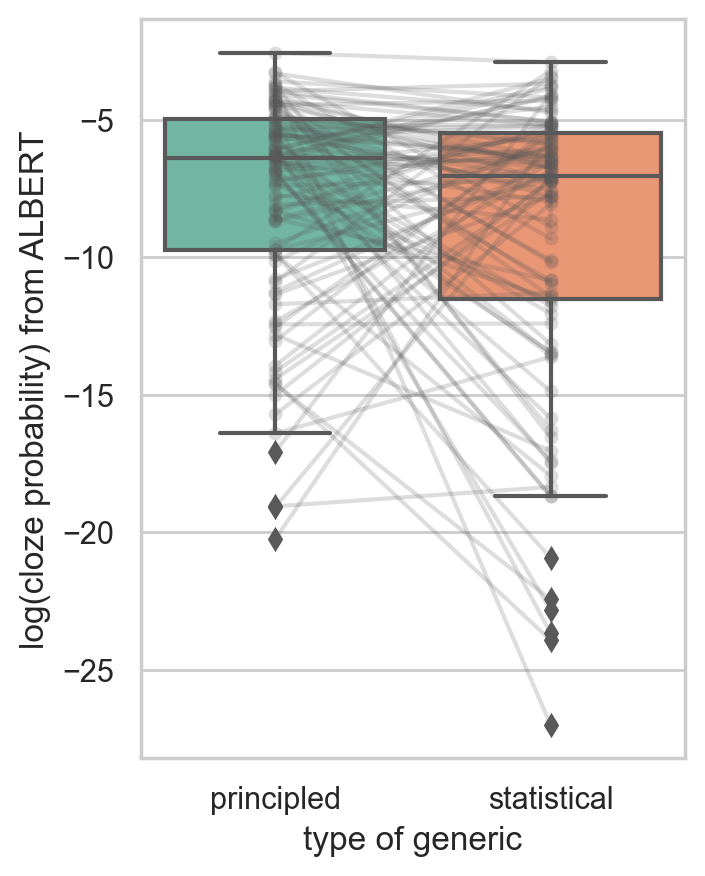

In [92]:
print(ttest_rel(df_mean.loc[df_mean.type == 'statistical', 'bert_cloze_logp'],
                df_mean.loc[df_mean.type == 'principled', 'bert_cloze_logp']))

ax = plt.subplot(111, aspect=.1)

sns.boxplot(
    data=df_mean,
    x='type', order=['principled', 'statistical'],
    hue='type', hue_order=['principled', 'statistical'],
    y='bert_cloze_logp',
    dodge=False,
    ax=ax
)

sns.stripplot(
    data=df_mean,
    x='type', order=['principled', 'statistical'],
    y='bert_cloze_logp',
    color='.35',
    alpha=.2,
    dodge=False,
    jitter=False,
    ax=ax
)
sns.lineplot(
    data=df_mean,
    x='type',
    y='bert_cloze_logp',
    units='subject',
    estimator=None,
    color='.35',
    alpha=.2,
    ax=ax
)
ax.legend().remove()
ax.set(
    ylabel='log(cloze probability) from ALBERT',
    xlabel='type of generic'
)
plt.savefig('figures/albert_log_cloze_prob.pdf', bbox_inches='tight')

TtestResult(statistic=1.5105391711773961, pvalue=0.13396774835636077, df=103)


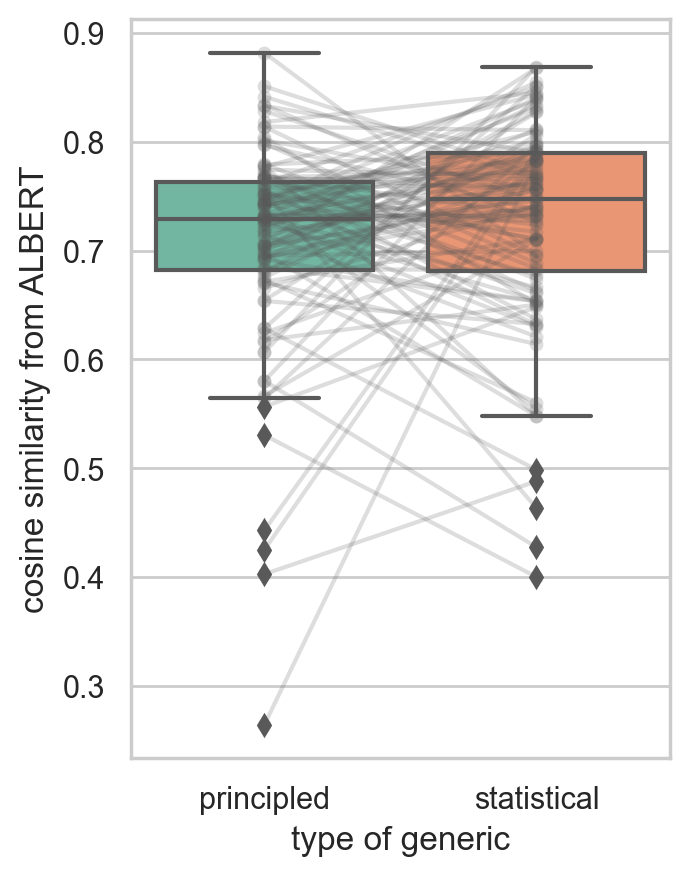

In [93]:
print(ttest_rel(df_mean.loc[df_mean.type == 'statistical', 'bert_cosine'],
                df_mean.loc[df_mean.type == 'principled', 'bert_cosine']))

ax = plt.subplot(111, aspect=4)

sns.boxplot(
    data=df_mean,
    x='type', order=['principled', 'statistical'],
    hue='type', hue_order=['principled', 'statistical'],
    y='bert_cosine',
    dodge=False,
    ax=ax
)

sns.stripplot(
    data=df_mean,
    x='type', order=['principled', 'statistical'],
    y='bert_cosine',
    color='.35',
    alpha=.2,
    dodge=False,
    jitter=False,
    ax=ax
)
sns.lineplot(
    data=df_mean,
    x='type',
    y='bert_cosine',
    units='subject',
    estimator=None,
    color='.35',
    alpha=.2,
    ax=ax
)
ax.legend().remove()
ax.set(
    ylabel='cosine similarity from ALBERT',
    xlabel='type of generic'
)
plt.savefig('figures/albert_cosine.pdf', bbox_inches='tight')

In [94]:
sns.set(context='talk', palette='Set2', style='whitegrid')

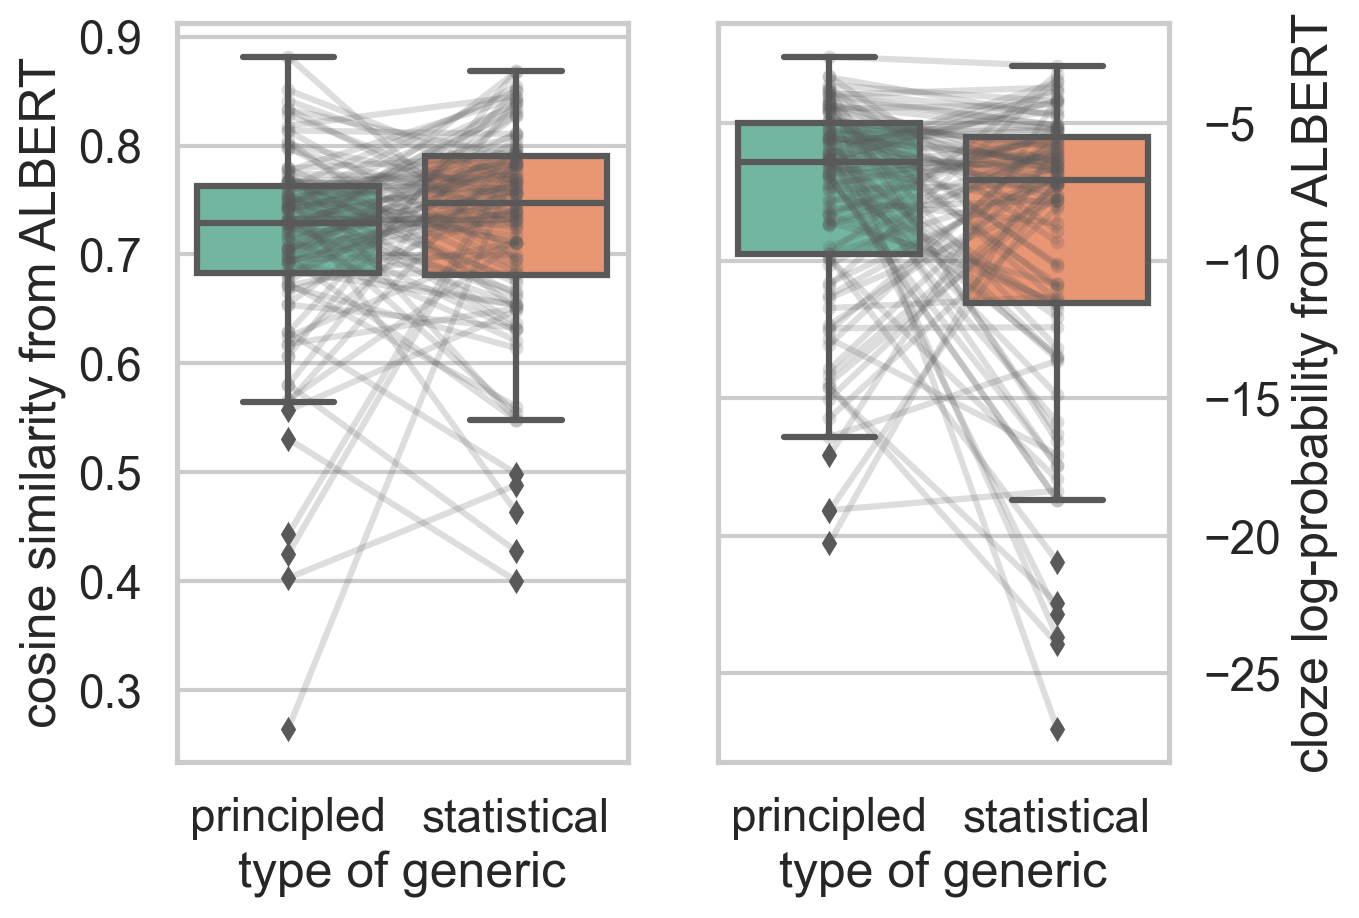

In [95]:
f, axes = plt.subplots(1, 2)

sns.boxplot(
    data=df_mean,
    x='type', order=['principled', 'statistical'],
    hue='type', hue_order=['principled', 'statistical'],
    y='bert_cosine',
    dodge=False,
    ax=axes[0],
)

sns.stripplot(
    data=df_mean,
    x='type', order=['principled', 'statistical'],
    y='bert_cosine',
    color='.35',
    alpha=.2,
    dodge=False,
    jitter=False,
    ax=axes[0]
)
sns.lineplot(
    data=df_mean,
    x='type',
    y='bert_cosine',
    units='subject',
    estimator=None,
    color='.35',
    alpha=.2,
    ax=axes[0]
)
axes[0].legend().remove()
axes[0].set(
    ylabel='cosine similarity from ALBERT',
    xlabel='type of generic'
)

sns.boxplot(
    data=df_mean,
    x='type', order=['principled', 'statistical'],
    hue='type', hue_order=['principled', 'statistical'],
    y='bert_cloze_logp',
    dodge=False,
    ax=axes[1],
)

sns.stripplot(
    data=df_mean,
    x='type', order=['principled', 'statistical'],
    y='bert_cloze_logp',
    color='.35',
    alpha=.2,
    dodge=False,
    jitter=False,
    ax=axes[1]
)
sns.lineplot(
    data=df_mean,
    x='type',
    y='bert_cloze_logp',
    units='subject',
    estimator=None,
    color='.35',
    alpha=.2,
    ax=axes[1]
)
axes[1].legend().remove()
axes[1].yaxis.set_label_position('right')
axes[1].yaxis.set_ticks_position('right')
axes[1].tick_params(right=False)
axes[1].set(
    ylabel='cloze log-probability from ALBERT',
    xlabel='type of generic'
)
plt.savefig('figures/both_boxplots.pdf', bbox_inches='tight')

In [99]:
print(spearmanr(df.groupby('item').mean(True).generic, df.groupby('item').mean(True).bert_cloze_logp))
print(spearmanr(df.groupby('item').mean(True).by_virtue_of, df.groupby('item').mean(True).bert_cloze_logp))
print(spearmanr(df.groupby('item').mean(True).prevalence, df.groupby('item').mean(True).bert_cloze_logp))
print(spearmanr(df.groupby('item').mean(True).cue_validity, df.groupby('item').mean(True).bert_cloze_logp))
print()
print(spearmanr(df.groupby('item').mean(True).generic, df.groupby('item').mean(True).bert_cosine))
print(spearmanr(df.groupby('item').mean(True).by_virtue_of, df.groupby('item').mean(True).bert_cosine))
print(spearmanr(df.groupby('item').mean(True).prevalence, df.groupby('item').mean(True).bert_cosine))
print(spearmanr(df.groupby('item').mean(True).cue_validity, df.groupby('item').mean(True).bert_cosine))

SignificanceResult(statistic=0.22428601309149024, pvalue=0.0011267668680277757)
SignificanceResult(statistic=0.11952917958296266, pvalue=0.0854949335769379)
SignificanceResult(statistic=0.17585110630009163, pvalue=0.011062853135896384)
SignificanceResult(statistic=-0.03810291210550977, pvalue=0.5847807863474144)

SignificanceResult(statistic=-0.08008571300059651, pvalue=0.25018501651255565)
SignificanceResult(statistic=-0.11359023080689715, pvalue=0.10233427517884372)
SignificanceResult(statistic=-0.1288468588011328, pvalue=0.06362532819133332)
SignificanceResult(statistic=-0.0835420286701774, pvalue=0.2302567316066396)


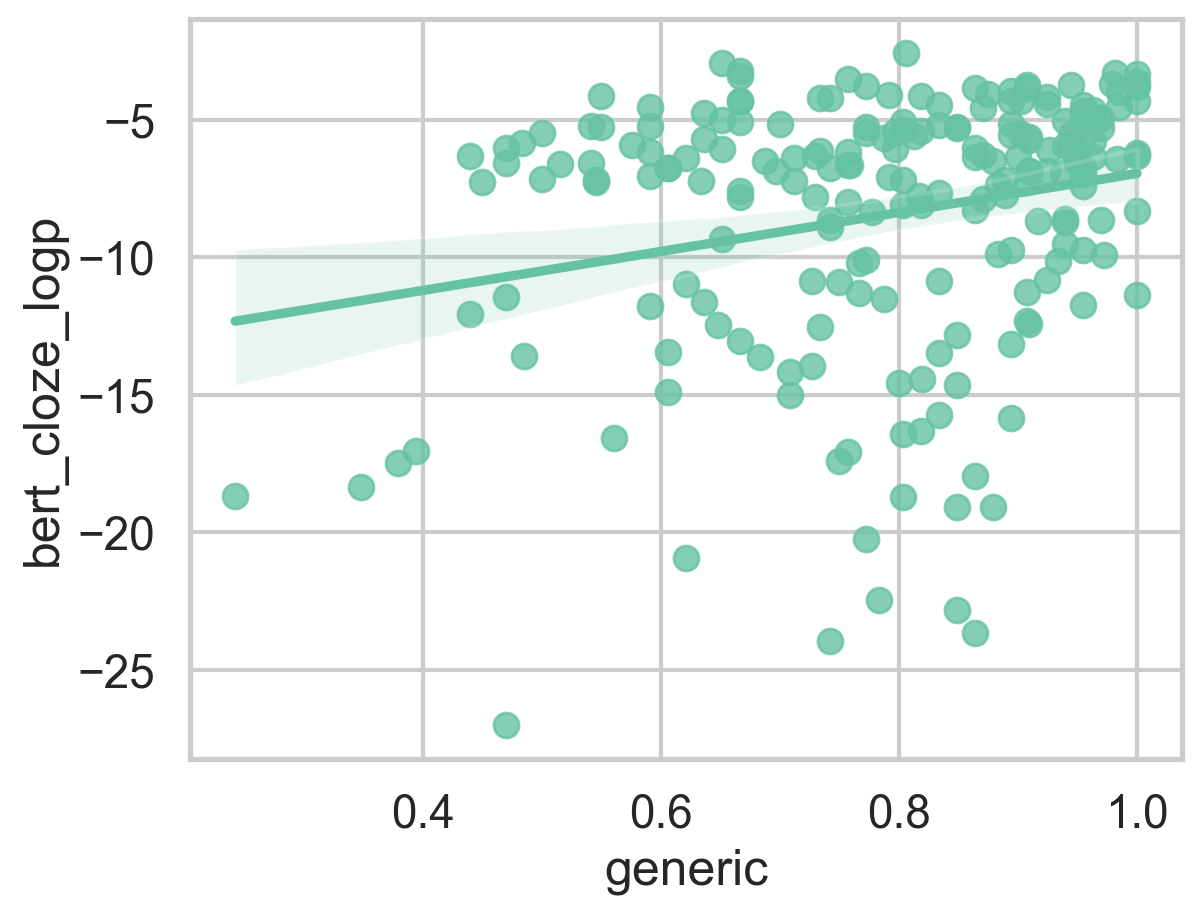

In [102]:
sns.regplot(
    data=df.groupby('item').mean(True),
    x='generic',
    y='bert_cloze_logp'
);

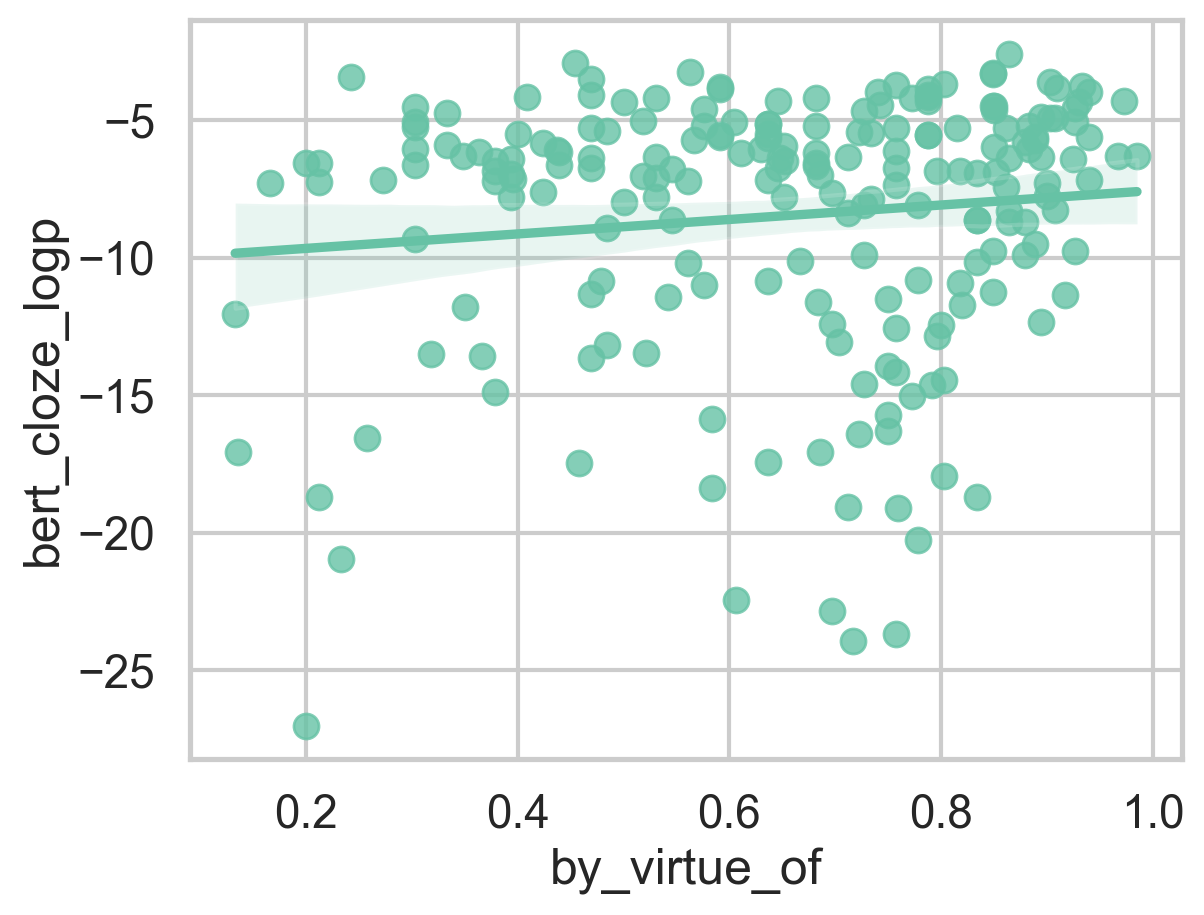

In [103]:
sns.regplot(
    data=df.groupby('item').mean(True),
    x='by_virtue_of',
    y='bert_cloze_logp'
);

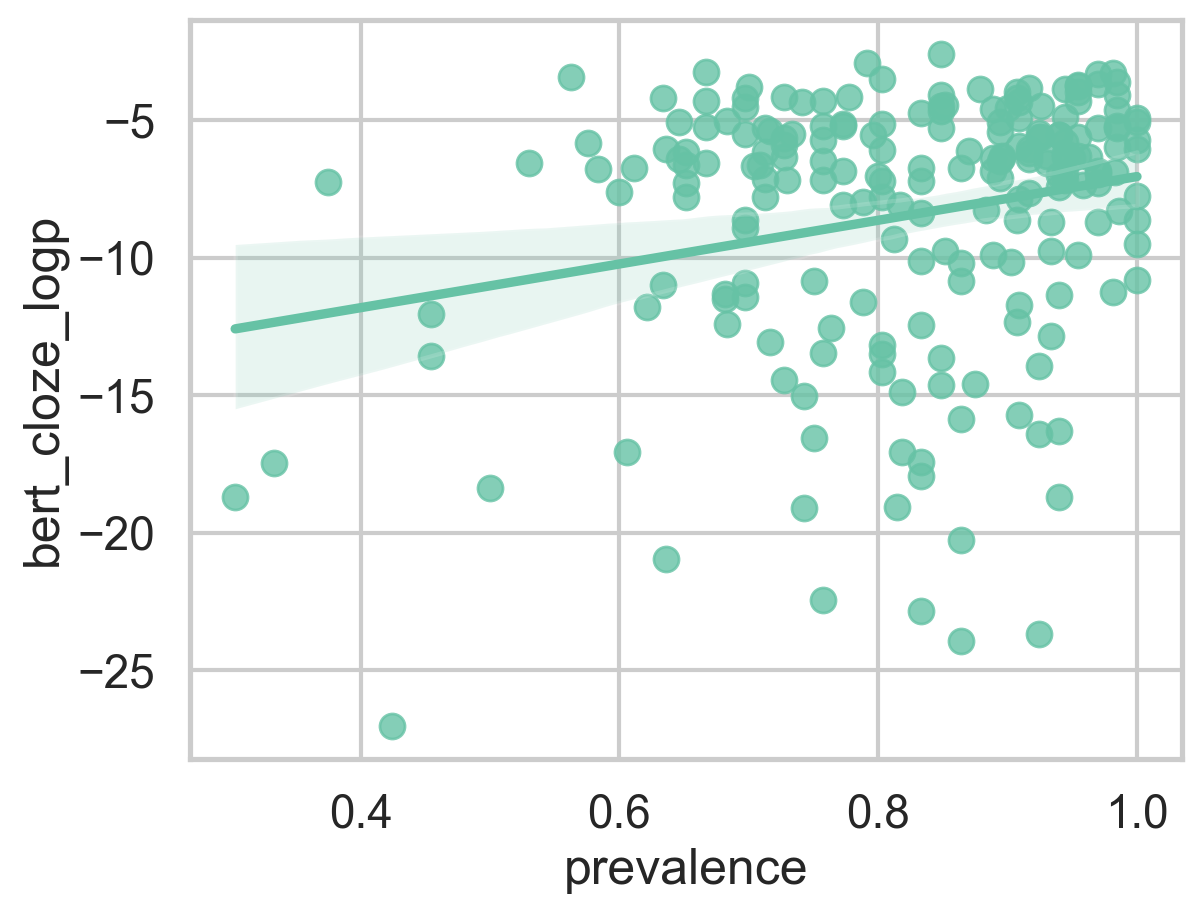

In [104]:
sns.regplot(
    data=df.groupby('item').mean(True),
    x='prevalence',
    y='bert_cloze_logp'
);

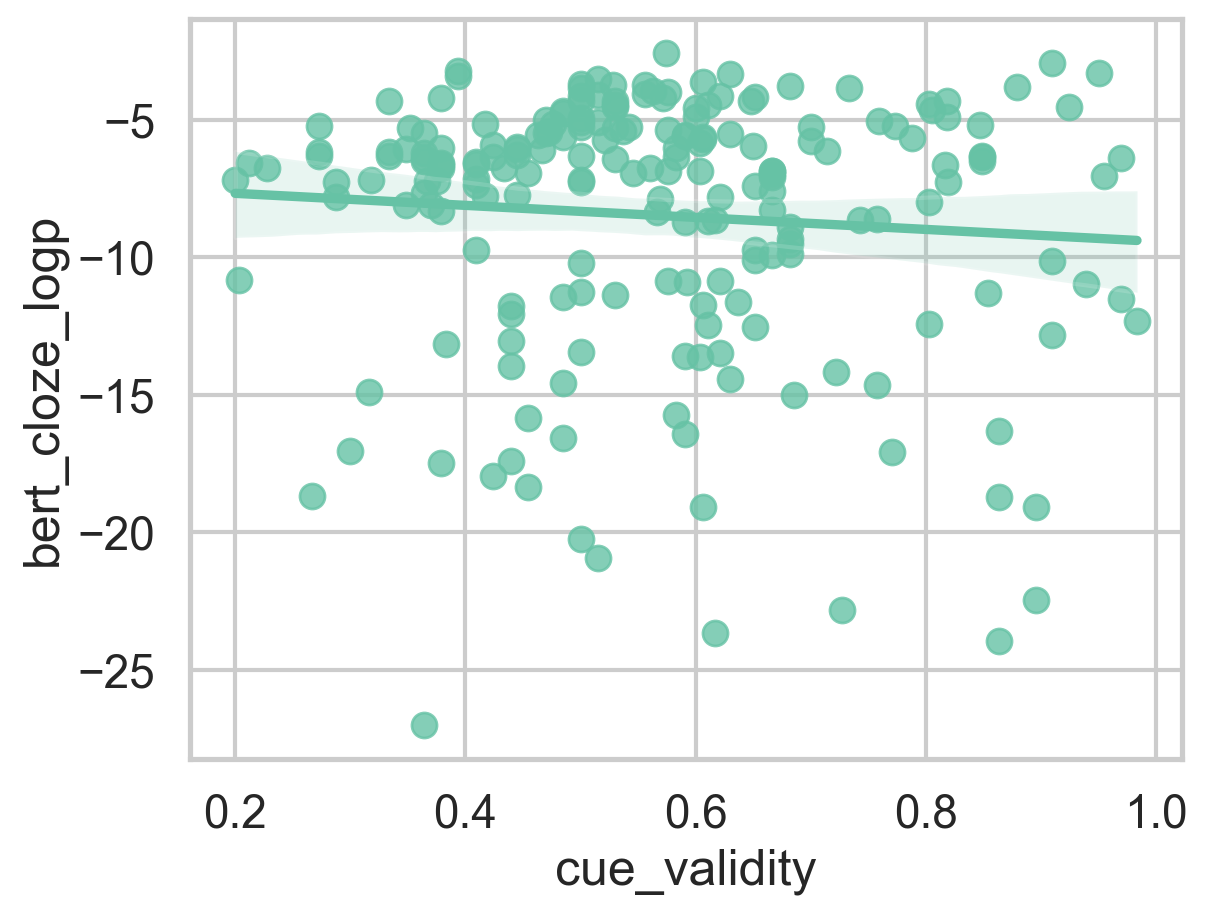

In [105]:
sns.regplot(
    data=df.groupby('item').mean(True),
    x='cue_validity',
    y='bert_cloze_logp'
);

## Linear models

In [106]:
%load_ext rpy2.ipython
%R library(lme4)
%R library(lmerTest)
%R -i df
%R -i df_mean

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Attaching package: ‘lmerTest’



    lmer



    step




### Effect of BERT cloze log probability on principled/statistical category

In [107]:
%R print(summary(glm(factor(type) ~ scale(bert_cloze_logp), family='binomial', data=df_mean)));
%R print(summary(glm(factor(type) ~ scale(bert_cloze_logp) + scale(mean_prevalence), family='binomial', data=df_mean)));


Call:
glm(formula = factor(type) ~ scale(bert_cloze_logp), family = "binomial", 
    data = df_mean)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5062  -1.1231  -0.1454   1.2139   1.3281  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)  
(Intercept)             0.003063   0.140209   0.022   0.9826  
scale(bert_cloze_logp) -0.299087   0.146116  -2.047   0.0407 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 288.35  on 207  degrees of freedom
Residual deviance: 283.95  on 206  degrees of freedom
AIC: 287.95

Number of Fisher Scoring iterations: 4


Call:
glm(formula = factor(type) ~ scale(bert_cloze_logp) + scale(mean_prevalence), 
    family = "binomial", data = df_mean)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5547  -0.6685  -0.1835   0.6975   2.1117  

Coefficients:
                       Estimate Std. 

### Effect of BERT cosine similarity on principled/statistical category

In [108]:
%R print(summary(glm(factor(type) ~ scale(bert_cosine), family='binomial', data=df_mean)));
%R print(summary(glm(factor(type) ~ scale(bert_cosine) + scale(mean_prevalence), family='binomial', data=df_mean)));


Call:
glm(formula = factor(type) ~ scale(bert_cosine), family = "binomial", 
    data = df_mean)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3252  -1.1865   0.1192   1.1513   1.4698  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)
(Intercept)        -0.0009194  0.1393436  -0.007    0.995
scale(bert_cosine)  0.1980965  0.1432226   1.383    0.167

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 288.35  on 207  degrees of freedom
Residual deviance: 286.38  on 206  degrees of freedom
AIC: 290.38

Number of Fisher Scoring iterations: 4


Call:
glm(formula = factor(type) ~ scale(bert_cosine) + scale(mean_prevalence), 
    family = "binomial", data = df_mean)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5657  -0.6901  -0.1573   0.7293   2.0924  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)              0.2062     0.1868   1.104     0.27    

### Effect of bare generic judgment on principled/statistical category

In [109]:
%R print(summary(glmer(factor(type) ~ scale(generic) + (1|pp), family='binomial', data=df)));
%R print(summary(glmer(factor(type) ~ scale(generic) + scale(mean_prevalence) + (1|pp), family='binomial', data=df)));

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(type) ~ scale(generic) + (1 | pp)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  2615.7   2632.7  -1304.8   2609.7     2181 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.6420 -0.6495 -0.2361  0.7490  1.5397 

Random effects:
 Groups Name        Variance Std.Dev.
 pp     (Intercept) 9.06e-14 3.01e-07
Number of obs: 2184, groups:  pp, 84

Fixed effects:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     0.07022    0.04806   1.461    0.144    
scale(generic) -1.05020    0.05974 -17.579   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
scale(gnrc) -0.194
optimizer (Nelder_Mead) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(type) ~ scale(generic) + scale(mean_prevalence) + (1 |      pp)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  1984.3   2007.1   -988.2   1976.3     2180 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.7227 -0.4970 -0.1301  0.5126  2.9792 

Random effects:
 Groups Name        Variance Std.Dev.
 pp     (Intercept) 0        0       
Number of obs: 2184, groups:  pp, 84

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)             0.19388    0.05793   3.347 0.000818 ***
scale(generic)         -0.44094    0.06652  -6.628  3.4e-11 ***
scale(mean_prevalence) -1.82772    0.08811 -20.743  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) scl(g)
scale(gnrc) -0.069       
scl(mn_prv) -0.225 -0.242
optimizer (N

In [110]:
%R print(summary(glm(factor(type) ~ scale(mean_generic), family='binomial', data=df_mean)));
%R print(summary(glm(factor(type) ~ scale(mean_generic) + scale(mean_prevalence), family='binomial', data=df_mean)));


Call:
glm(formula = factor(type) ~ scale(mean_generic), family = "binomial", 
    data = df_mean)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3506  -0.6518  -0.1641   0.6745   2.2412  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)           0.2377     0.1933   1.230    0.219    
scale(mean_generic)  -2.1697     0.2980  -7.281 3.32e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 288.35  on 207  degrees of freedom
Residual deviance: 182.98  on 206  degrees of freedom
AIC: 186.98

Number of Fisher Scoring iterations: 5


Call:
glm(formula = factor(type) ~ scale(mean_generic) + scale(mean_prevalence), 
    family = "binomial", data = df_mean)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6484  -0.5867  -0.1528   0.6202   2.3236  

Coefficients:
                       Estimate Std. Error z valu

### Effect of by-virtue-of judgment on principled/statistical category

In [111]:
%R print(summary(glmer(factor(type) ~ scale(by_virtue_of) + (1|pp), family='binomial', data=df)));
%R print(summary(glmer(factor(type) ~ scale(by_virtue_of) + scale(mean_prevalence) + (1|pp), family='binomial', data=df)));

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(type) ~ scale(by_virtue_of) + (1 | pp)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  2518.2   2535.3  -1256.1   2512.2     2181 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3304 -0.6442 -0.4826  0.7386  1.9969 

Random effects:
 Groups Name        Variance Std.Dev.
 pp     (Intercept) 0.06836  0.2615  
Number of obs: 2184, groups:  pp, 84

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          0.05299    0.05700    0.93    0.352    
scale(by_virtue_of) -1.18357    0.07160  -16.53   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
scl(by_vr_) -0.108
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(type) ~ sca

In [112]:
%R print(summary(glmer(factor(type) ~ scale(by_virtue_of) + scale(bert_cloze_logp) + (1|pp), family='binomial', data=df)));
%R print(summary(glmer(factor(type) ~ scale(by_virtue_of) + scale(bert_cloze_logp) + scale(mean_prevalence) + (1|pp), family='binomial', data=df)));

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(type) ~ scale(by_virtue_of) + scale(bert_cloze_logp) +  
    (1 | pp)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  2489.9   2512.6  -1240.9   2481.9     2180 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0028 -0.6599 -0.4344  0.7553  2.1988 

Random effects:
 Groups Name        Variance Std.Dev.
 pp     (Intercept) 0.06909  0.2628  
Number of obs: 2184, groups:  pp, 84

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)             0.05688    0.05737   0.992    0.321    
scale(by_virtue_of)    -1.17885    0.07180 -16.419  < 2e-16 ***
scale(bert_cloze_logp) -0.27832    0.05134  -5.421 5.93e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) scl(by__)
scl(by_vr_) -0.102          
scl(brt_c_) -0.025  0.053 

In [113]:
%R print(summary(glmer(factor(type) ~ scale(by_virtue_of) + scale(bert_cosine) + (1|pp), family='binomial', data=df)));
%R print(summary(glmer(factor(type) ~ scale(by_virtue_of) + scale(bert_cosine) + scale(mean_prevalence) + (1|pp), family='binomial', data=df)));

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(type) ~ scale(by_virtue_of) + scale(bert_cosine) + (1 |  
    pp)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  2500.0   2522.8  -1246.0   2492.0     2180 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5522 -0.6609 -0.3143  0.7449  2.5499 

Random effects:
 Groups Name        Variance Std.Dev.
 pp     (Intercept) 0.06614  0.2572  
Number of obs: 2184, groups:  pp, 84

Fixed effects:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          0.04937    0.05695   0.867    0.386    
scale(by_virtue_of) -1.18144    0.07156 -16.511  < 2e-16 ***
scale(bert_cosine)   0.22676    0.05126   4.423 9.72e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sc(__)
scl(by_vr_) -0.105       
scl(brt_cs) -0.017 -0.059
Generalized linear mix

In [114]:
%R print(summary(glmer(factor(type) ~ scale(prevalence) + (1|pp), family='binomial', data=df)));
%R print(summary(glmer(factor(type) ~ scale(prevalence) + scale(mean_prevalence) + (1|pp), family='binomial', data=df)));

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(type) ~ scale(prevalence) + (1 | pp)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  2673.0   2690.1  -1333.5   2667.0     2181 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.6344 -0.6888 -0.2690  0.9953  1.4519 

Random effects:
 Groups Name        Variance Std.Dev.
 pp     (Intercept) 0        0       
Number of obs: 2184, groups:  pp, 84

Fixed effects:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)        0.06535    0.04739   1.379    0.168    
scale(prevalence) -0.97791    0.05966 -16.391   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
scl(prvlnc) -0.195
optimizer (Nelder_Mead) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')

Generalized linear mixed model fit by maximum likelihood (La

In [115]:
%R print(summary(glmer(factor(type) ~ scale(cue_validity) + (1|pp), family='binomial', data=df)));
%R print(summary(glmer(factor(type) ~ scale(cue_validity) + scale(mean_prevalence) + (1|pp), family='binomial', data=df)));

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: factor(type) ~ scale(cue_validity) + (1 | pp)
   Data: df

     AIC      BIC   logLik deviance df.resid 
  2977.7   2994.7  -1485.8   2971.7     2169 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.3119 -0.9540  0.7622  0.9680  1.2293 

Random effects:
 Groups Name        Variance Std.Dev.
 pp     (Intercept) 0        0       
Number of obs: 2172, groups:  pp, 84

Fixed effects:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          0.002335   0.043306   0.054    0.957    
scale(cue_validity) -0.272164   0.043823  -6.210 5.28e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
scl(c_vldt) -0.005
optimizer (Nelder_Mead) convergence code: 0 (OK)
boundary (singular) fit: see help('isSingular')

Generalized linear mixed model fit by maximum lik